## LSTM Model
### First Part: Hyperparameter

### Hyperparameter
Note: Since increasing the number of layers did not significantly reduce the error and added more parameters, resulting in greater computational overhead and the risk of overfitting, we ultimately chose one layer as the optimal hyperparameter.

## Part two: Train and Test

c:\Users\cloudcine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
  6%|▋         | 32/500 [00:00<00:03, 139.32it/s]

Epoch [30/500]  Loss: 0.003393

 12%|█▏        | 62/500 [00:00<00:03, 142.89it/s]

Epoch [70/500]  Loss: 0.001268

 18%|█▊        | 92/500 [00:00<00:02, 138.20it/s]

Epoch [100/500]  Loss: 0.001198

 24%|██▍       | 120/500 [00:00<00:02, 131.77it/s]

Epoch [130/500]  Loss: 0.001135

 32%|███▏      | 160/500 [00:01<00:02, 122.00it/s]

Epoch [160/500]  Loss: 0.001071

 37%|███▋      | 186/500 [00:01<00:02, 121.80it/s]

Epoch [190/500]  Loss: 0.001005

 42%|████▏     | 212/500 [00:01<00:02, 123.29it/s]

Epoch [220/500]  Loss: 0.000937

 50%|█████     | 252/500 [00:01<00:01, 126.74it/s]

Epoch [250/500]  Loss: 0.000870

 56%|█████▌    | 280/500 [00:02<00:01, 129.53it/s]

Epoch [280/500]  Loss: 0.000822

 61%|██████    | 306/500 [00:02<00:01, 122.59it/s]

Epoch [310/500]  Loss: 0.000786

 70%|███████   | 350/500 [00:02<00:01, 136.22it/s]

Epoch [350/500]  Loss: 0.000737

 76%|███████▌  | 378/500 [00:02<00:00, 134.69it/s]

Epoch [380/500]  Loss: 0.000701

 81%|████████  | 406/500 [00:03<00:00, 136.01it/s]

Epoch [410/500]  Loss: 0.000673

 87%|████████▋ | 434/500 [00:03<00:00, 137.04it/s]

Epoch [440/500]  Loss: 0.000646

 95%|█████████▌| 476/500 [00:03<00:00, 137.38it/s]

Epoch [470/500]  Loss: 0.000632

100%|██████████| 500/500 [00:03<00:00, 131.64it/s]


Epoch [500/500]  Loss: 0.000612

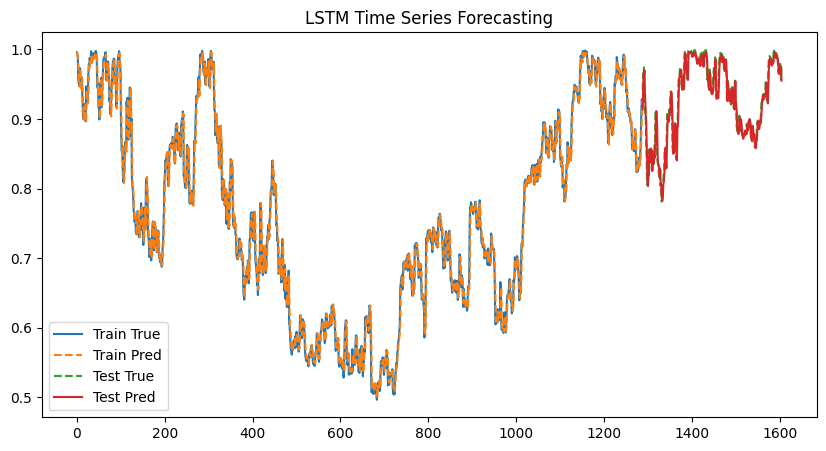

In [130]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

window_size = 7
epochs = 500
hidden_size = 64
num = 1
LR = 0.01


df = pd.read_csv('./data/BTC_factors/addresses/BTC_1h_profit_relative.csv')
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
start_time = '2021-01-01 00:00:00'
df = df.sort_values('datetime')
df.set_index(df.columns[0], inplace=True)
df = df.resample('D').mean()    
df = df[start_time:]
values = df["profit_relative"].values.astype(float)
values =values.reshape(-1,1)
train_size = int(len(values) * 0.8)
train_data_raw = values[:train_size]
test_data_raw = values[train_size:]

# 2. 只用训练数据拟合scaler
scaler = MinMaxScaler()
train_data= scaler.fit_transform(train_data_raw)

# 3. 用训练数据的scaler转换测试数据
test_data= scaler.transform(test_data_raw)

def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)



X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# 转为 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=hidden_size, num_layers=num):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)              # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]                # 取最后一个时间步的输出
        out = self.fc(out)
        return out

model = LSTMModel()

criterion = nn.SmoothL1Loss()  # 平滑且对异常值不敏感
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
from tqdm import tqdm

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"\rEpoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}", end="")

model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

# 反归一化到原始数值
train_pred = scaler.inverse_transform(train_pred.numpy())
y_train_true = scaler.inverse_transform(y_train.numpy())    

test_pred = scaler.inverse_transform(test_pred.numpy())
y_test_true = scaler.inverse_transform(y_test.numpy())

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(len(y_train_true)), y_train_true, label="Train True")
plt.plot(range(len(train_pred)), train_pred, linestyle="--",label="Train Pred")

plt.plot(range(len(y_train_true), len(y_train_true)+len(y_test_true)), y_test_true, linestyle="--",label="Test True")
plt.plot(range(len(y_train_true), len(y_train_true)+len(y_test_true)), test_pred,label="Test Pred")
plt.legend()
plt.title("LSTM Time Series Forecasting")
plt.show()

## Final result and comparison

In [131]:
MSE = np.mean((test_pred-y_test_true)**2)
MAE = np.mean(np.abs(test_pred-y_test_true))
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((test_pred-y_test_true)/y_test_true))
MASE = np.mean(np.abs(y_test_true-test_pred))/np.mean(np.abs(np.array(y_test_true[1:])-np.array(y_test_true[:-1])))
result= [{'Method':' LSTM','RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'MASE':MASE}]
result_frame = pd.DataFrame(result)
result_frame

,Method,RMSE,MAE,MAPE,MASE
0,LSTM,0.0135,0.009752,0.010669,1.037205
